<a href="https://colab.research.google.com/github/petert92/Cat-Dog_Classification_FreeCodeCamp/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and dog image classification
As an exercise from the ML course from Free Code Camp I developed this model. The J notebook was provided from the course with some instructions and I completed the rest. Here is the assigment:
}https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/cat-and-dog-image-classifier

The structure of the dataset files that are downloaded looks like this:
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

In [1]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Codeing/FreeCodeCamp/Cat&Dog_classification

/content/drive/MyDrive/Codeing/FreeCodeCamp/Cat&Dog_classification


In [ ]:
#@ Imports
!pip install icecream
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

In [ ]:
#@title Get the data
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))
print('train:',total_train, 'val:', total_val, 'test:', total_test)

train: 2001 val: 1001 test: 2


In [ ]:
#@title Hyperparameters
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
#title Preprocesing images
train_image_generator = ImageDataGenerator(rescale=1./255.0)
validation_image_generator = ImageDataGenerator(rescale=1./255.0)
test_image_generator = ImageDataGenerator(rescale=1./255.0)

train_data_gen = train_image_generator.flow_from_directory(train_dir, (IMG_HEIGHT, IMG_WIDTH), class_mode= 'binary', batch_size = batch_size)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, (IMG_HEIGHT, IMG_WIDTH), class_mode= 'binary', batch_size = batch_size)
test_data_gen = test_image_generator.flow_from_directory(test_dir, (IMG_HEIGHT, IMG_WIDTH), class_mode= 'binary', batch_size = batch_size, shuffle = False)

## Plot images
The `plotImages` takes an array of images and a probabilities list, although the probabilities list is optional.

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


## Image Data Augmentation
Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Transformation parameters:
- rescale (must)
- rotation_range: tipacally used
- witdth/height_shitf_range: some images are a small animal in the center
- brightness_range: change the brightness as in real life
- shear_range: perspectived view
- zoom_range
- horizontal_flip: mirror on vertical axe, no vertical cause it isn't a usual photo

In [ ]:
rescale=1./255.0
rotation_range=15
width_shift_range=0.1
height_shift_range=0.1
brightness_range=(0.5,1.5)
shear_range= 15
zoom_range= 0.2
horizontal_flip=True

train_image_generator = ImageDataGenerator(rescale=rescale, rotation_range=rotation_range, width_shift_range=width_shift_range, \
                                           height_shift_range=height_shift_range, brightness_range=brightness_range, \
                                           shear_range= shear_range, zoom_range= zoom_range, horizontal_flip= horizontal_flip)


In [ ]:
# Plot some transformated images
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Model architecture

Architecure taken from Machine Learning Mastery, Jason Brownlee. Modifications: one VGG block less because the dataset is small; jump from 32 kernels to 128.
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = Sequential()
 # 1st block
model.add(Conv2D(32, (3,3), padding='same', activation= 'relu', input_shape= input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2)) 
# 2nd block
model.add(Conv2D(128, (3,3),  padding='same', activation= 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3), loss= tf.keras.losses.BinaryCrossentropy(), metrics= ['accuracy'])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 128)       36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 128)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 37, 37, 128)      

## Train and plot performance

In [ ]:
history = model.fit(train_data_gen, steps_per_epoch=len(train_data_gen), epochs= epochs, validation_data=val_data_gen, validation_steps=len(val_data_gen))

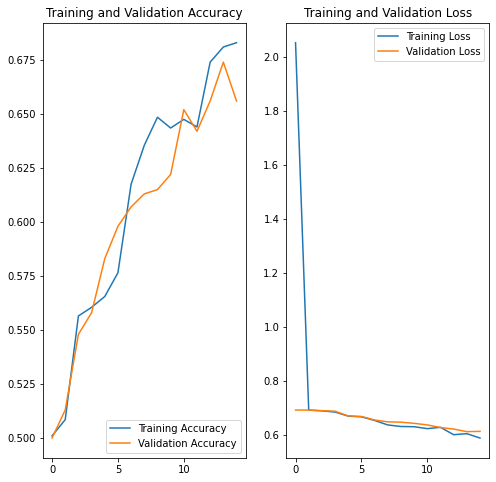

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions
Make predictions with test data and check if pass the challenge.

In [ ]:
probabilities = model.predict(test_data_gen)
probabilities[:5]
plotImages(test_data_gen[0][0], probabilities)

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.7% of the images of cats and dogs.
You passed the challenge!


## Notes
I tried 3 differents hyperparameters:
batchzise = 128 and 3x VGG blocks -> 70%
batchzise = 64 and 3x VGG blocks -> 66%
batchzise = 128 and 2x VGG blocks  -> 70%

I didn't take more epochs because there aren't so many datapoints and I just wanna tried a few things without takeing too many time.